### Collaborative Filtering on UK Parliament Data

We will analyse data collected by [Public Whip](http://www.publicwhip.org.uk/) on the votes each Member of Parliament (MP) has cast during the 2010-2015 parliament in the House of Commons. Each vote corresponds to a particular piece of legislature and is called a _division_. Download these data [here](http://www.stats.ox.ac.uk/%7Esejdinov/teaching/dmml/parliament2010.dat) and to load use:

In [1]:
library(readr)
df <- read_csv("~/data/publicwhip/parliament2010.dat")
votes <- df[,2:1227]
dim(votes)

Parsed with column specification:
cols(
  .default = col_integer(),
  mpidstr = col_character(),
  firstname = col_character(),
  surname = col_character(),
  party = col_character()
)
See spec(...) for full column specifications.


[1]  664 1226

There are 664 MPs and 1226 divisions. In the data matrix `votes`, $+1$ indicates an `aye` on the division, $-1$ a `no`. $0$ indicates that the MP did not vote in that particular division. In reality, it is a bit more complicated than this as there are also _tellers_ as well as the MPs who voted both ways (!), but I cleaned up the original format so that we can treat it as a simple binary dataset (with missing values). Now let us consider the number of votes each MP has cast. It turns out that there is a huge range in these: there is an MP who voted only once(!), whereas another one voted in 1179 out of 1226 divisions.

In [2]:
#find number of votes cast - 
nz<-apply(votes,1,function(x) sum(x!=0))
summary(nz)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0   776.8   888.0   841.6   973.2  1179.0 

In [3]:
df$surname[nz<5]

[1] "Primarolo" "Hoyle"

Ah, ok, those MPs who voted a very small number of times are actually the two _deputy speakers_ - they don't traditionally vote. Let us remove them and recompute the number of votes cast.

In [4]:
df<-df[nz>=5,]
votes<-votes[nz>=5,]

#recompute number of votes cast
nz<-apply(votes,1,function(x) sum(x!=0))
summary(nz)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   38.0   779.0   888.5   844.1   973.8  1179.0 

To start with, let us ignore the fact that votes which were not cast are essentially missing data (due to MPs not attending sessions, for example) and simply run PCA on this data matrix. Note that $p>n$ here so let us do SVD (don't forget to center the data matrix first!).

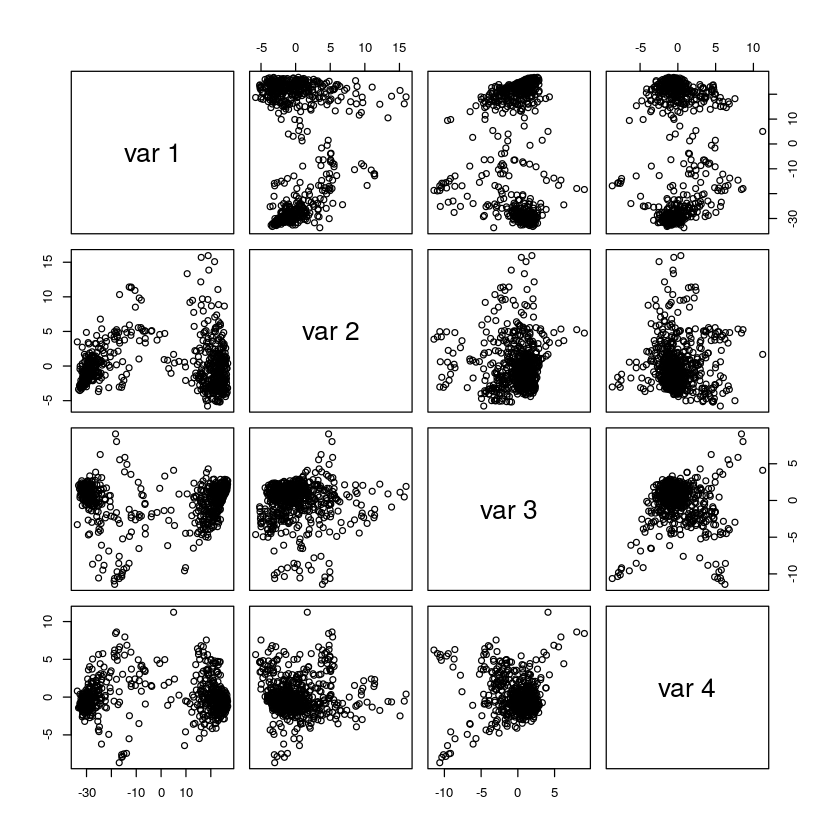

In [5]:
#center the data
y <- scale(votes, scale = FALSE)
#summary(colMeans(y))

npc<-4
y.svd <- svd(y,nu=npc,nv=npc)

proj<-y.svd$u %*% diag(y.svd$d[1:npc])

#plot pca projections
pairs(proj)

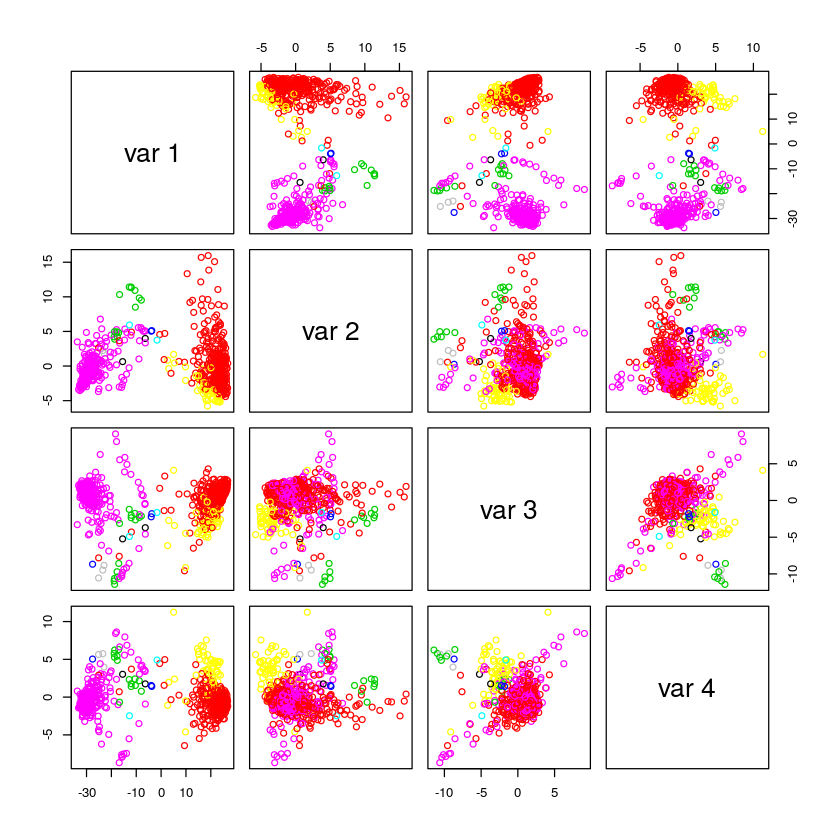

In [7]:
#now plot with party membership
party=factor(df$party)
pairs(proj,col=party)

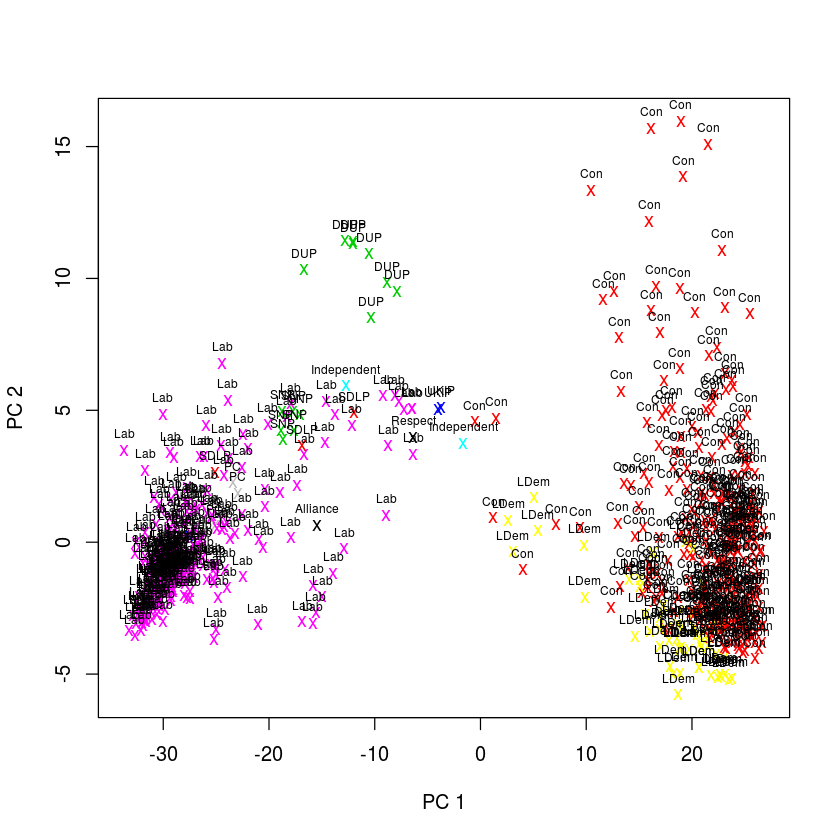

In [21]:
plot(proj[,1:2],col=party,pch='x',xlab='PC 1',ylab='PC 2')
text(proj[,1:2],labels=party,pos=3,cex=0.6)

The first two principal components indicate a good split between the major parties: red are Conservatives, yellow are the Liberal Democrats and purple is Labour. What about MPs in each of these parties who are located towards the middle? Is it an indication of outlier MPs - some form of rebelliousness? Not really -- MPs close to the middle just don't vote much! The plot of the number of votes cast versus the distance from the mean in the principal components projections reveals this.

[1] "correlation: 0.660324306181162"


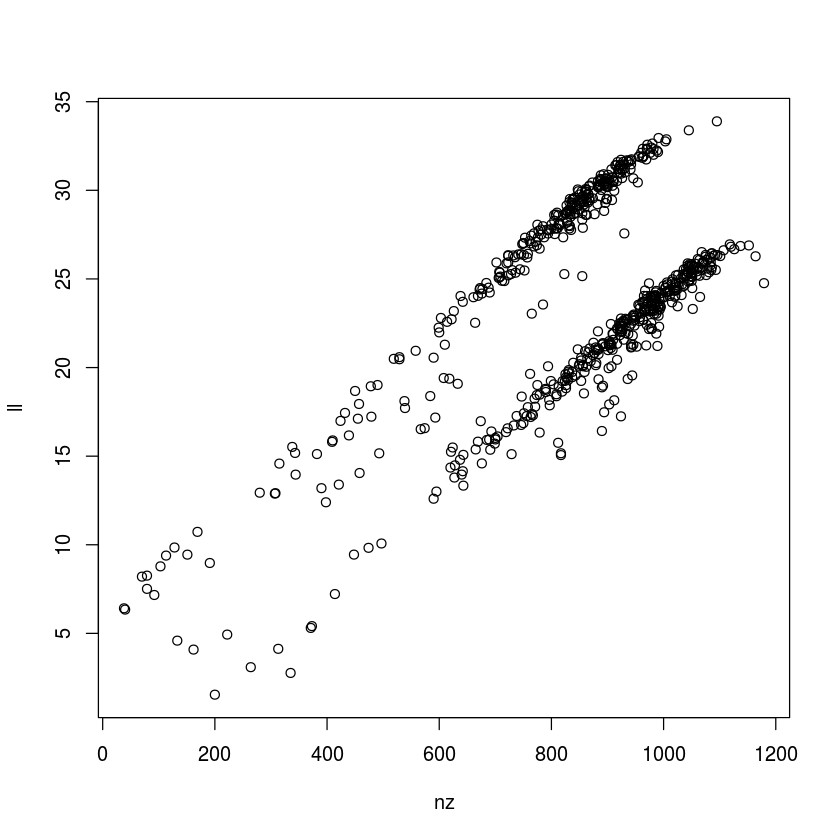

In [19]:
#find lengths of the vectors of projections
ll<-apply(proj[,1:2],1,function(x) sqrt(sum(x^2)))


#the points pulled towards the mean are not indication of rebelliousness but of not voting often!
plot(nz,ll)
print(paste('correlation:',cor(nz,ll)))

This also becomes apparent when we look at the actual names of MPs. Indeed, those close to the middle are actually members of the cabinet who do not vote that often: `Cameron`, `Clegg`, `Osborne`, `Hague` (which is hardly a rebellious crowd).  

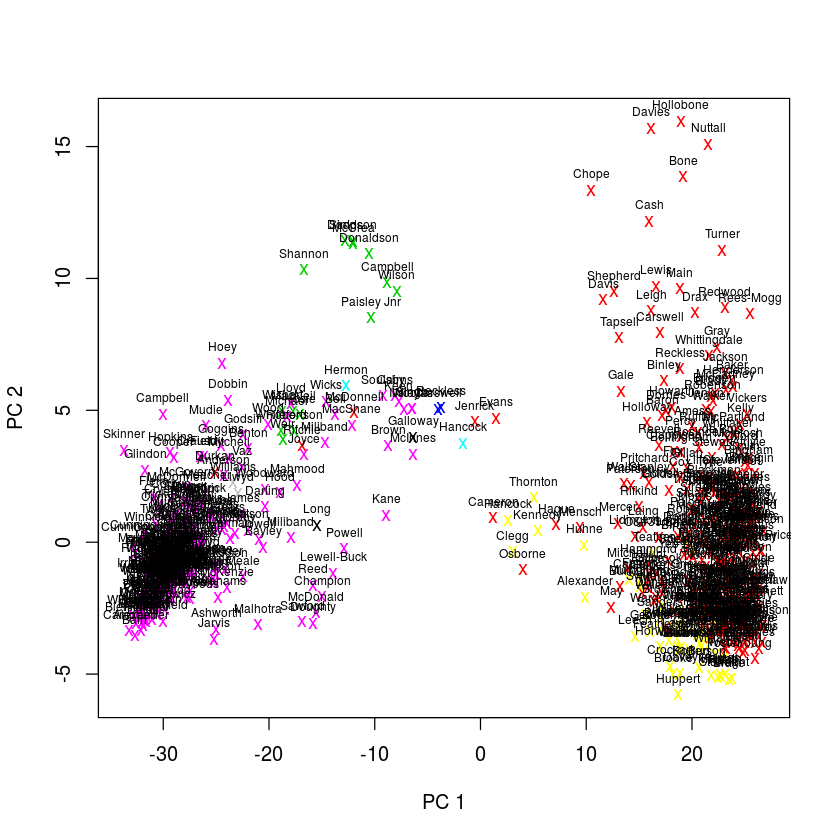

In [22]:
plot(proj[,1:2],col=party,pch='x',xlab='PC 1',ylab='PC 2')
text(proj[,1:2],labels=df$surname,pos=3,cex=0.6)

To deal with this issue we will treat the problem as collaborative filtering and make two enhancements to the model: first, we will now treat the 0s as missing data as is common in collaborative filtering; second, we will actually make use of the fact that the observations are binary (`aye`, `no`) and use a generalised linear model with logistic links.

Let us run a few alternating _logistic_ regressions, where we initialise the latent MP attributes to the left singular vectors and the latent division attributes to the right singular vectors (both rescaled with the square roots of the singular values). 

Below is the implementation which uses `sgd` package for performing $L_2$-regularised logistic regression with stochastic gradient descent (SGD). This is still pretty slow as I am doing exact updates for each latent vector one-by-one. You should be smarter than this and implement SGD on the overall objective function as discussed in the lectures.

In [23]:
library(sgd)
n1=dim(votes)[1]
n2=dim(votes)[2]
k=2

Phi=y.svd$u[,1:k] %*% diag(sqrt(y.svd$d[1:k]))
Psi=y.svd$v[,1:k] %*% diag(sqrt(y.svd$d[1:k]))

In [24]:
TT<-3
for(tt in 1:TT){
  for(jj in 1:n2){
    idx=which(votes[,jj]!=0)
    Psi[jj,]=sgd(formula = as.integer(0.5*t(votes[idx, jj])+1) ~ Phi[idx,]-1,
                 model="glm", model.control=list(family=binomial(link="logit"),lambda2=0.01))$coefficients[,1]
    }
  for(ii in 1:n1){
    idx=which(votes[ii,]!=0)
    Phi[ii,]=sgd(formula = as.integer(0.5*votes[ii, idx]+1) ~ Psi[idx,]-1,
                  model="glm", model.control=list(family=binomial(link="logit"),lambda2=0.01))$coefficients[,1]
    }
  
}

But hey, it worked! Clusters are split further apart and cabinet members are moved to the middle of the conservative cluster.

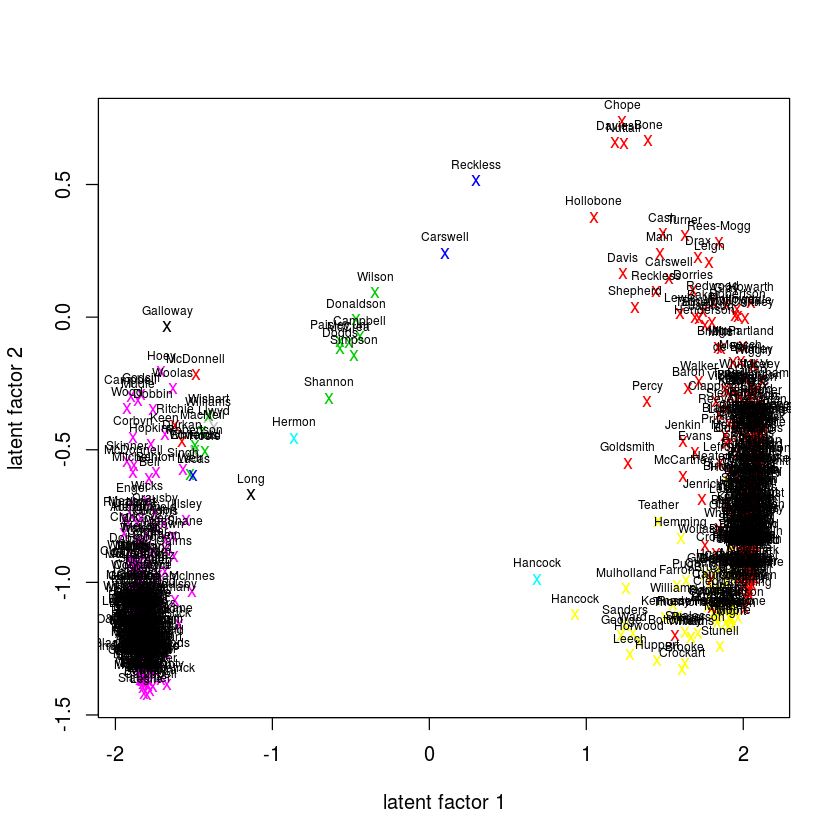

In [25]:
plot(Phi,col=party,pch='x',,xlab='latent factor 1',ylab='latent factor 2')
text(Phi,labels=df$surname,pos=3,cex=0.6)

Again, compute the distances of the latent vectors from their mean (mean no longer needs to be zero as it was in the case for singular vector projections). There is no correlation anymore, so being far away from the party centre can now indeed be interpreted as a different voting pattern.

[1] "correlation: 0.0324912554308771"


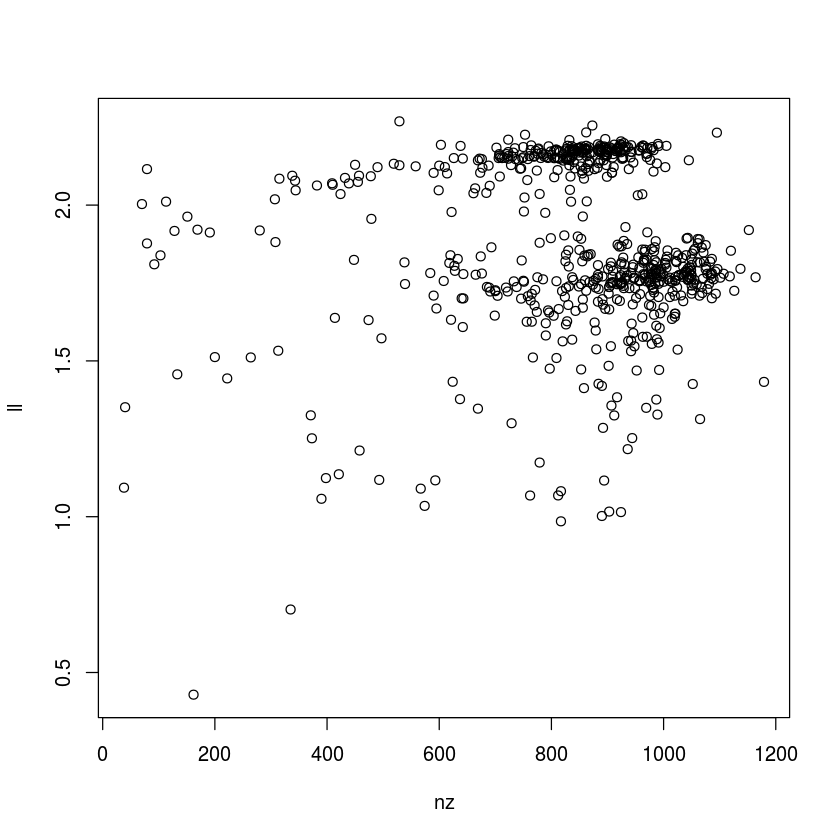

In [26]:
meanphi<-colMeans(Phi)
ll<-apply(Phi,1,function(x) sqrt(sum((x-meanphi)^2)))


plot(nz,ll)
print(paste('correlation:',cor(nz,ll)))